Even though the network is not as accurate as I wish it to be, this is an attempt at seeing what the output will be like.

In [1]:
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import numpy as np 
import pandas as pd
import os 
import soundfile as sf
from __future__ import division

from make_CFcall_training_data import calculate_snippet_features, max_normalise_each_channel
from make_CFcall_training_data import make_9number_to_class_converter

Using TensorFlow backend.


In [2]:
# load neural network and weights:
with open('CF_classifier_1jandata_9class.json' ,'r') as model_json:
    n = models.model_from_json(model_json.read())
n.load_weights('CF_classifier1jandata_9class.h5')
n.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

In [3]:
n.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 198, 32)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 98, 16)            1040      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 49, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 297       
Total para

In [4]:
date_2_folder_paths = {
        '2018-08-16' : os.path.join('audio', '2018-08-16/'),
        '2018-08-18' : os.path.join('audio', '2018-08-18/'),
        '2018-08-19' : os.path.join('audio', '2018-08-19', 'ch1/',)
                        }
path_to_datafolder = os.path.join('/media', 'tbeleyur', 'THEJASVI_DATA_BACKUP_3',
                                  'fieldwork_2018_002', 'horseshoe_bat',
                                  )
file_numbers = range(830,986)
file_names = ['T0000'+str(filenum)+'.WAV' for filenum in file_numbers]

In [5]:
chunks = np.array_split(np.arange(60*250000),300)

In [6]:
%%time
# break each audio file into 200 ms chunks and calculate features
all_features = np.zeros((len(chunks)*len(file_names),200,5))
i = 0 
for one_file in file_names:
    file_path = os.path.join(path_to_datafolder,date_2_folder_paths['2018-08-18'],one_file)
    for each_chunk in chunks:
        try:
            audio, fs = sf.read(file_path, start=each_chunk[0], stop=each_chunk[-1]+1,  dtype='float32')
            audio_snip = audio[:,0]
            features = calculate_snippet_features(audio_snip, 250)
            all_features[i,:,:] = max_normalise_each_channel(features)
            i += 1
        except :
            pass
        

/home/tbeleyur/anaconda2/envs/horseshoebat/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


CPU times: user 31min 56s, sys: 33.3 s, total: 32min 30s
Wall time: 35min 58s


In [7]:
features.shape

(200, 5)

In [8]:
# run class predictions :
predicted = n.predict_classes(all_features)
predicted_onehot = to_categorical(predicted)
# covert number to snippet type
conv_num_to_sniptype = make_9number_to_class_converter()
predicted_types = map(lambda X : conv_num_to_sniptype[X], range(9))

In [9]:
predicted_onehot.shape

(46800, 9)

In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


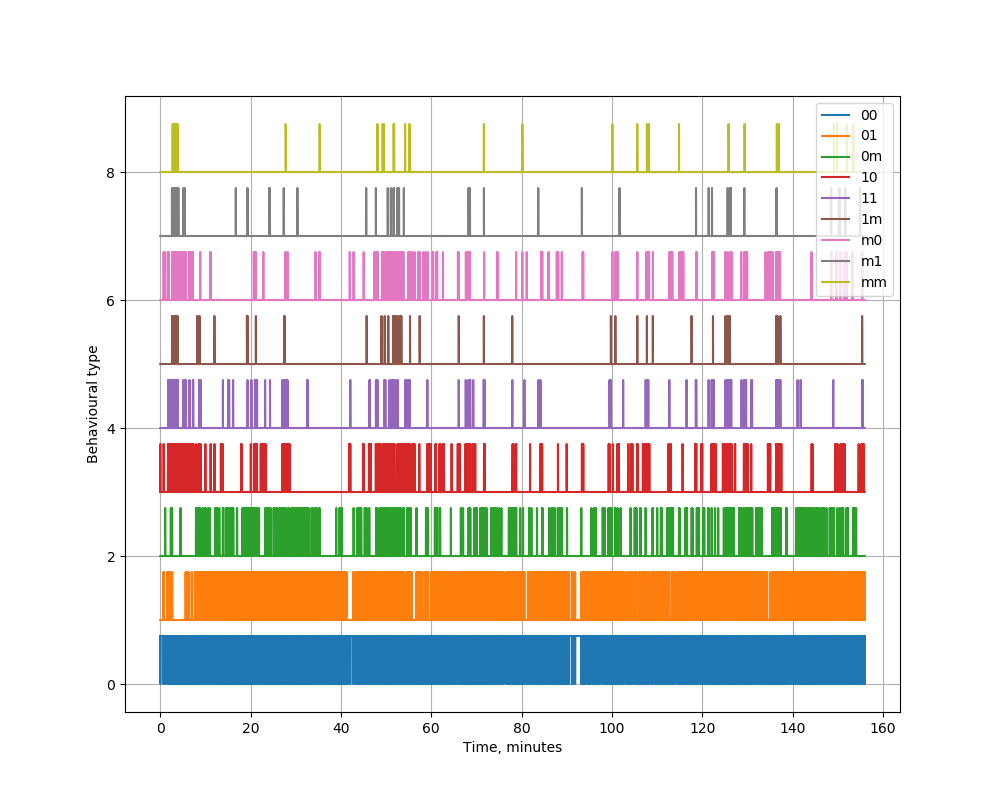

In [11]:
plt.figure(figsize=(10,8))
for each_type in range(9):
    plt.plot(np.arange(0,predicted_onehot.shape[0]*0.2,0.2)/60,
             predicted_onehot[:,each_type]*0.75+each_type,
             label=predicted_types[each_type])

plt.ylabel('Behavioural type')
plt.xlabel('Time, minutes')
plt.grid()
plt.legend()

In [12]:
np.mean(predicted_onehot,0)

array([0.7571581 , 0.15205128, 0.02019231, 0.05373932, 0.00467949,
       0.00136752, 0.00865385, 0.00113248, 0.00102564], dtype=float32)

<IPython.core.display.Javascript object>


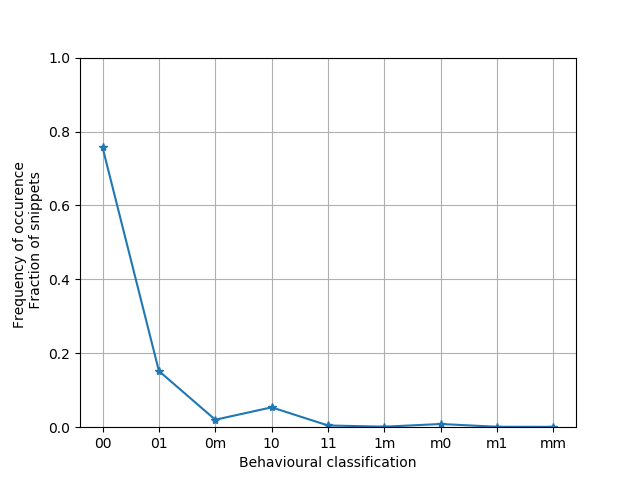

Text(0.5,0,'Behavioural classification')

In [15]:
ax = plt.figure().add_subplot(111)
plt.plot(np.arange(1,10),np.mean(predicted_onehot, 0),'*-')
ax.set_xticks(np.arange(1,10))
ax.set_xticklabels(predicted_types);
plt.ylim(0,1);plt.grid(); plt.ylabel('Frequency of occurence \n Fraction of snippets')
plt.xlabel('Behavioural classification')